In [1]:
# Import required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler, OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

# Hide warnings in the notebook
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# Import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [3]:
# Set plots properties
sns.set_style('darkgrid')

In [4]:
# Dataset url
file_url = 'https://raw.githubusercontent.com/faadeola/credit-risk-ml-prediction/refs/heads/main/credit_risk_dataset.csv'

# Read dataset for analysis
credit = pd.read_csv(file_url)

# Actual column names
feature_desc_mapping = {
    'person_age' : 'Age',
    'person_income' : 'Annual Income',
    'person_home_ownership' : 'Home Ownership',
    'person_emp_length' : 'Employment Length (in years)',
    'loan_intent' : 'Loan Intent',
    'loan_grade' : 'Loan Grade',
    'loan_amnt' : 'Loan Amount',
    'loan_int_rate' : 'Interest Rate (%)',
    'loan_status' : 'Loan Status',
    'loan_percent_income' : 'Percent Income',
    'cb_person_default_on_file' : 'Historical Default',
    'cb_person_cred_hist_length' : 'Credit History Length'
    }

In [5]:
#vShow 10 random rows in the dataset
credit.sample(frac=0.15)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
29520,38,33000,RENT,2.0,VENTURE,D,2000,16.89,1,0.06,N,14
18143,28,159000,RENT,5.0,PERSONAL,D,6000,15.95,1,0.04,N,10
22093,31,52000,MORTGAGE,8.0,HOMEIMPROVEMENT,A,6400,7.88,0,0.12,N,10
11583,24,69600,RENT,2.0,PERSONAL,A,10000,8.38,0,0.14,N,2
26679,27,110000,MORTGAGE,8.0,VENTURE,B,30000,11.11,0,0.27,N,6
...,...,...,...,...,...,...,...,...,...,...,...,...
26090,30,96000,MORTGAGE,14.0,VENTURE,A,6000,5.42,0,0.06,N,7
24632,35,59000,RENT,5.0,PERSONAL,C,10000,13.49,1,0.17,Y,10
24720,29,75000,MORTGAGE,4.0,DEBTCONSOLIDATION,C,14400,13.92,0,0.19,N,9
20745,28,42240,OWN,2.0,MEDICAL,B,12000,11.86,0,0.28,N,6


# Exploratory Data Analysis and Feature Engineering
This section explores the data file further to understand the structure and distribution

In [6]:
# Shape of the dataset
print(f'Data has {credit.shape[0]} rows and {credit.shape[1]} columns')

Data has 32581 rows and 12 columns


In [7]:
# General overview of the dataset
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [8]:
# Display statistical information about the numerical columns
credit.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.73,6.35,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.85,61983.12,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.79,4.14,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.37,6322.09,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.01,3.24,5.42,7.90,10.99,13.47,23.22
loan_status,32581.0,0.22,0.41,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.17,0.11,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.80,4.06,2.00,3.00,4.00,8.00,30.00


In [9]:
# Check for duplicates in data
has_duplicates = credit.duplicated().sum()

print(f'{has_duplicates} duplicates found in the data')

# Drop duplicates if any
credit.drop_duplicates(keep='first', ignore_index=True, inplace=True)

165 duplicates found in the data


In [10]:
""" Group numerical and categorical data type"""
numerical_columns = credit.select_dtypes(include=['int64','float64']).drop(columns='loan_status') #For numerical data types
categorical_columns = credit.select_dtypes(include='object') #For categorical data types

In [11]:
# Get all unique values for categorical columns
for column in categorical_columns:
  print(f'{column}: {credit[column].unique()}')

person_home_ownership: ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent: ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
loan_grade: ['D' 'B' 'C' 'A' 'E' 'F' 'G']
cb_person_default_on_file: ['Y' 'N']


In [12]:
# Checks for null values
credit.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,887
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,3095
loan_status,0
loan_percent_income,0


In [13]:
""" Fill missing values in the order of Mode (categorical data) and Mean (Numerical data) """

#Fill categorical data
for column in categorical_columns:
    if credit[column].isnull().sum() > 0:
        credit[column] = credit[column].fillna(credit[column].mode())

# Fill numerical data
for column in numerical_columns:
    if credit[column].isnull().sum() > 0:
        credit[column] = credit[column].fillna(credit[column].mean())

In [14]:
# Check if null value still exists
credit.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_status,0
loan_percent_income,0


In [15]:
credit['loan_intent'] = credit['loan_intent'].str.replace('DEBTCONSOLIDATION','Debt Consolidation').str.replace('HOMEIMPROVEMENT','Home Improvement')
credit['loan_intent'].value_counts()

,count
loan_intent,
EDUCATION,6411
MEDICAL,6042
VENTURE,5682
PERSONAL,5498
Debt Consolidation,5189
Home Improvement,3594


In [16]:
# Standardized values in the object columns to title case
for column in categorical_columns:
    credit[column] = credit[column].str.strip().str.title()

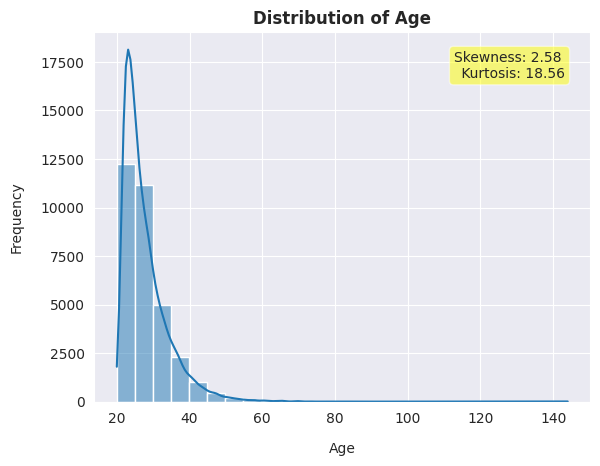

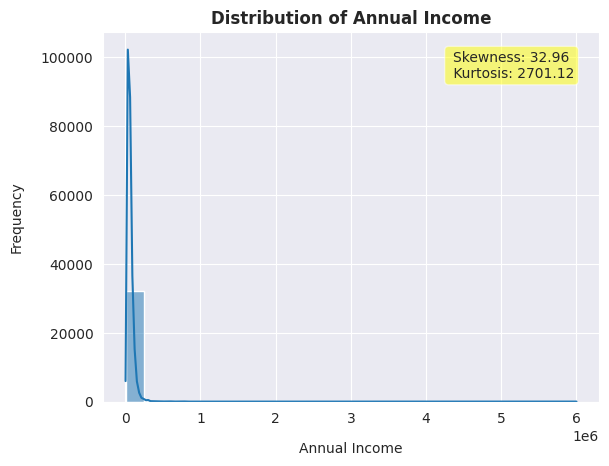

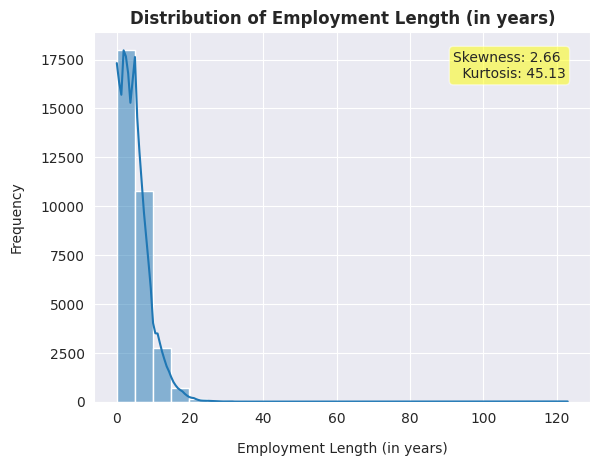

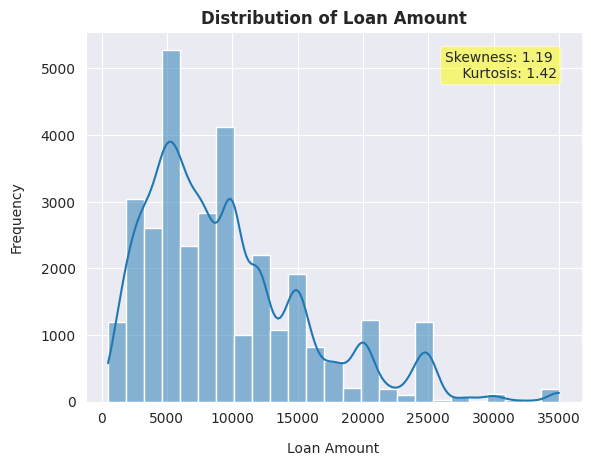

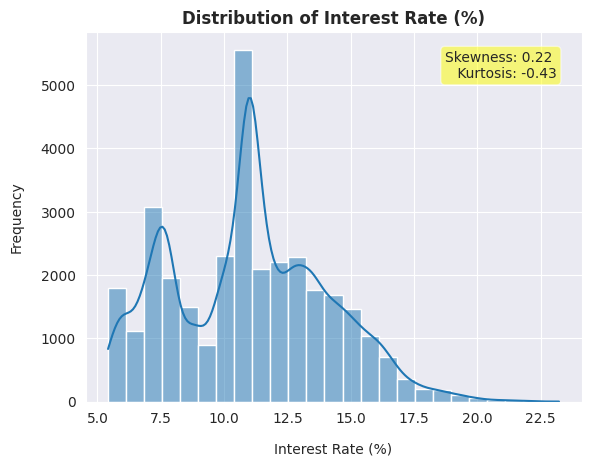

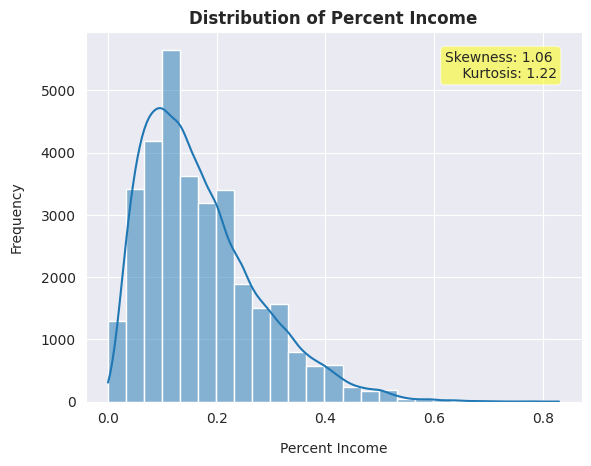

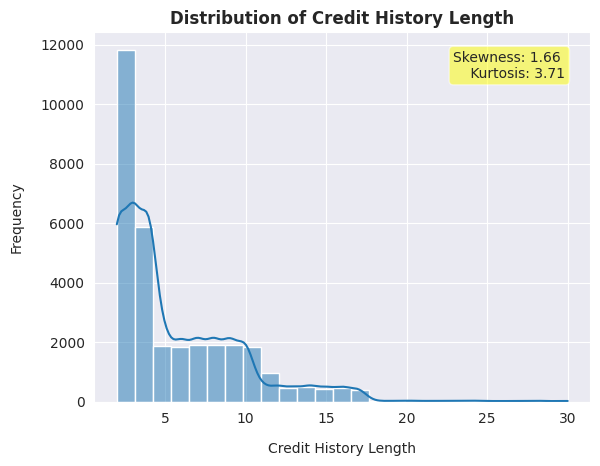

In [17]:
# Plot histogram of the numerical columns in the dataset to understand data distributions
for col in numerical_columns:
  fig, ax = plt.subplots()
  sns.histplot(credit[col],kde=True, bins=25)
  plt.title(f'Distribution of {feature_desc_mapping[col]}', fontweight='semibold')
  plt.text(0.95,0.95,f'Skewness: {credit[col].skew():.2f} \n Kurtosis: {credit[col].kurtosis():.2f}', transform = ax.transAxes, horizontalalignment = 'right', verticalalignment = 'top', bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))
  plt.xlabel(f'{feature_desc_mapping[col]}', labelpad=12)
  plt.ylabel('Frequency', labelpad=12)
  plt.show()

  # Print line break after each plot
  print('\n')

In [18]:
''' Check for outliers in the data'''

def get_outlier(column):
    # This function returns the outliers in a column

    Q1 = credit[column].quantile(0.25)
    Q3 = credit[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - (1.5 * IQR) #--Get the lower bound values
    upper_bound = Q3 + (1.5 * IQR) #--Get the upper bound values

    outliers = ((credit[column] < lower_bound) | (credit[column] > upper_bound))

    return outliers, outliers.sum()

# Dictionary to hold outliers in each columns
outlier_dict = {}

# Get the number of outliers in each column
for col in numerical_columns.columns:
    col_outlier = get_outlier(col)[1] # Stores number of outlier in a column
    outlier_dict[col] = col_outlier # Add value and key to dictionary

# Display dictionary information as a DataFrame
outlier_df = pd.DataFrame({'Outlier Count': outlier_dict})
outlier_df.head()

,Outlier Count
person_age,1491
person_income,1478
person_emp_length,852
loan_amnt,1679
loan_int_rate,70


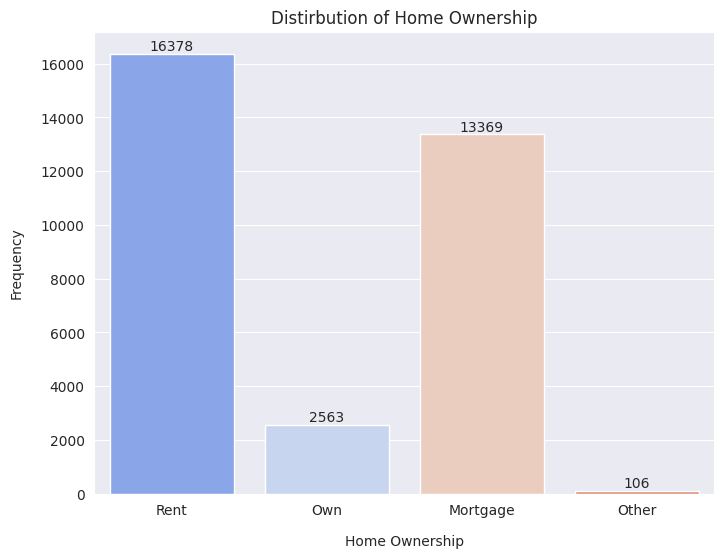

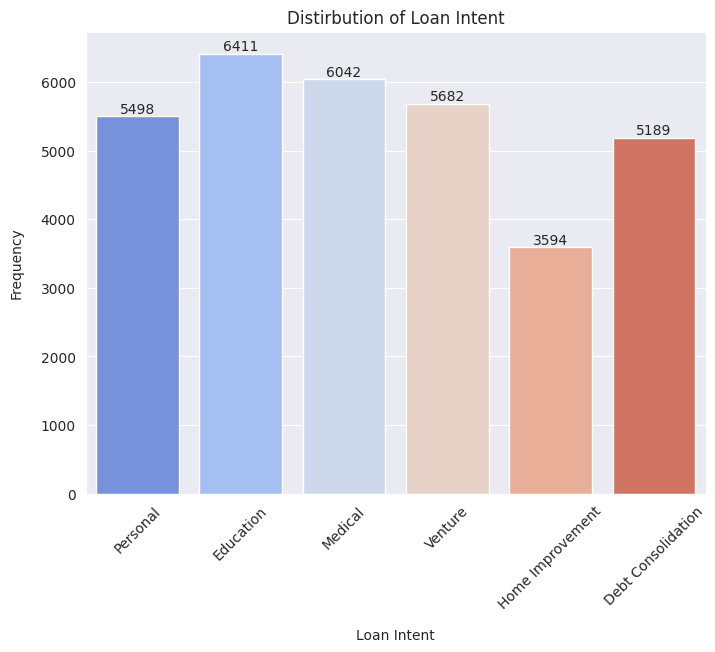

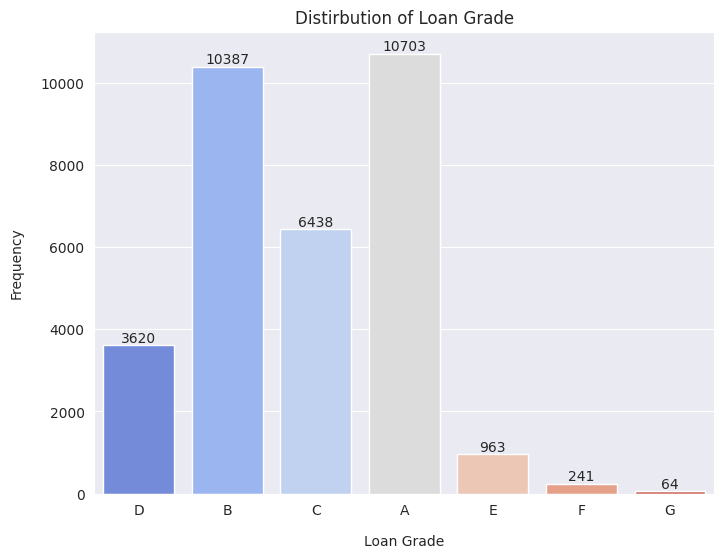

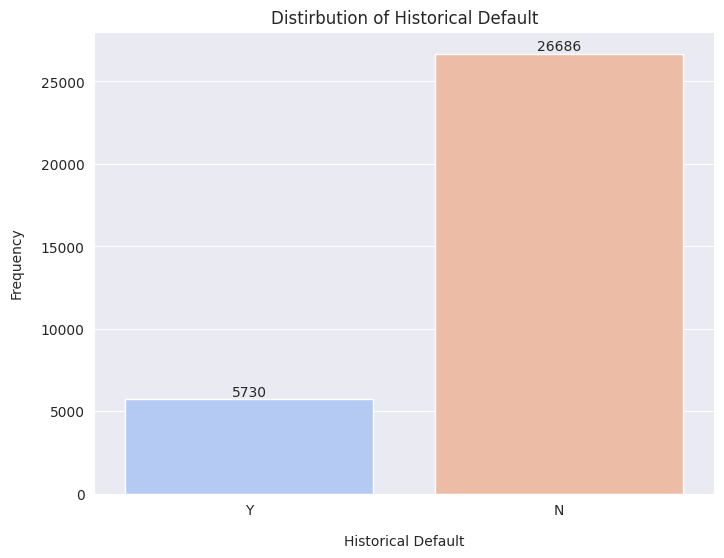

In [19]:
# Display count plot to understand distribution of categorical data
for col in categorical_columns.columns:
  fig,ax = plt.subplots(figsize=(8,6), dpi=100)
  sns.countplot(data=credit, x= f'{col}', palette='coolwarm', ax=ax)
  plt.title(f'Distirbution of {feature_desc_mapping[col]}')
  plt.xlabel(f'{feature_desc_mapping[col]}', labelpad=12)

  if col == 'loan_intent':
    plt.xticks(rotation=45)

  plt.ylabel('Frequency', labelpad=12)

  # Add count labels on top of each bar
  for container in ax.containers:
      ax.bar_label(container, fmt='%d', label_type='edge')

  plt.show()

  # Print line break after each plot
  print('\n')

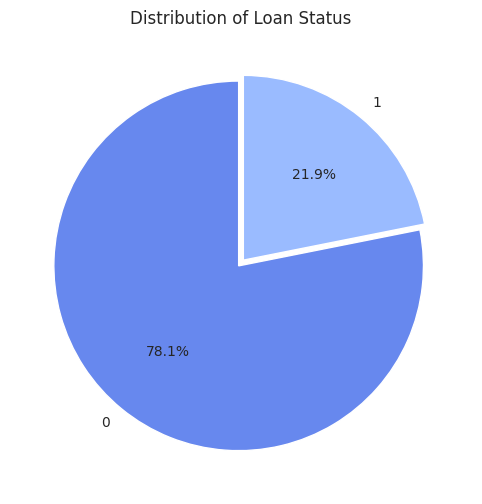

In [20]:
# Distribution of target feature
frequency = credit['loan_status'].value_counts()
fig,ax= plt.subplots(figsize=(8,6))
plt.pie(frequency.values, labels=frequency.index, autopct='%1.1f%%', startangle=90, explode=[0.02,0.02], colors=sns.color_palette('coolwarm'))
plt.title('Distribution of Loan Status')
plt.show()

In [21]:
# print out value count for loan status
credit['loan_status'].value_counts().reset_index()

,loan_status,count
0,0,25327
1,1,7089


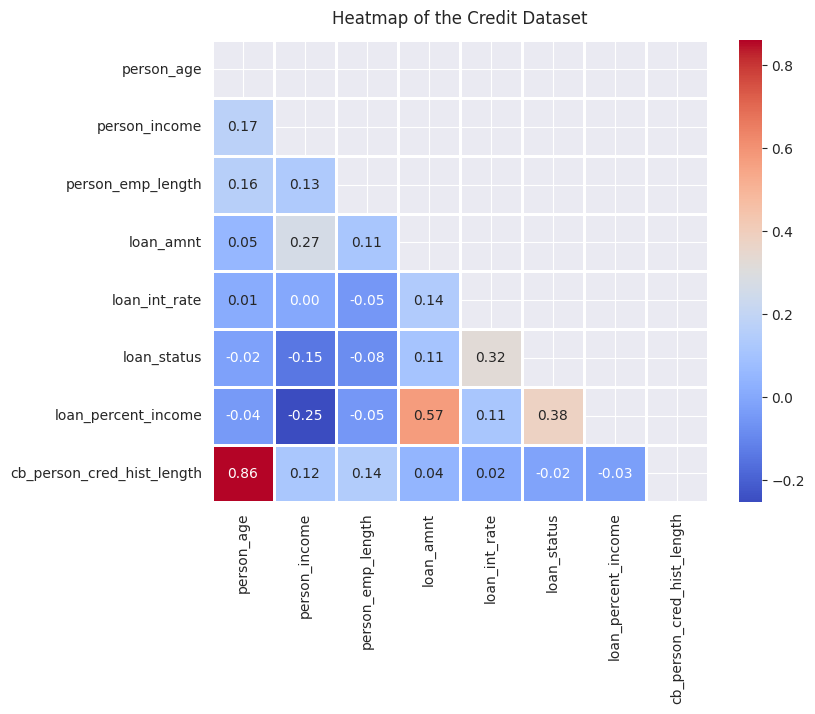

In [22]:
# Heat map of credit data
credit_corr = credit.corr(numeric_only=True)
mask = np.triu(np.ones_like(credit_corr))
plt.subplots(figsize=(8,6))
sns.heatmap(data=credit_corr, mask=mask, fmt='.2f', annot=True, cmap='coolwarm', linewidths=2, cbar=True)
plt.title('Heatmap of the Credit Dataset', pad=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [23]:
"""Classify person into age groups"""
# categorize age into groups
bin = [20,30,40,50,60,120]
age_label = ['20-30','31-40','41-50','51-60','60 and above']

# create group and add to daataset as a new column
credit['Age group'] = pd.cut(credit['person_age'],bins=bin, labels=age_label, right=True, include_lowest=True)

In [24]:
# Transform credit history to numerical column
credit['cb_person_default_on_file'] = np.where(credit['cb_person_default_on_file']=='Y',1,0).astype('int')

In [25]:
# Remove outliers across all numerical columns
def remove_outliers(numerical_cols):
    """
    Removes rows where numerical columns has an outlier.
    """
    row_mask = pd.Series(True, index=credit.index)

    for col in numerical_cols:
        col_outliers = get_outlier(col)[0]
        row_mask = row_mask & (~col_outliers)

    return credit[row_mask].copy()

# Assign clean data to initial dataframe name
credit = remove_outliers(numerical_columns)

In [26]:
# Check the new shape of the data
print(f'The dataframe now have {credit.shape[0]} rows and {credit.shape[1]} columns after removing outliers')

The dataframe now have 26833 rows and 13 columns after removing outliers


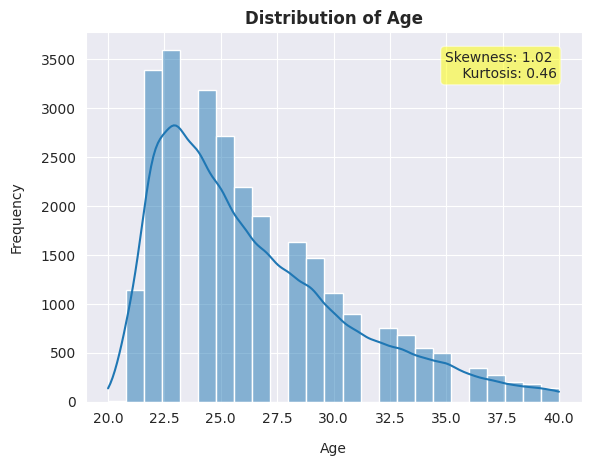

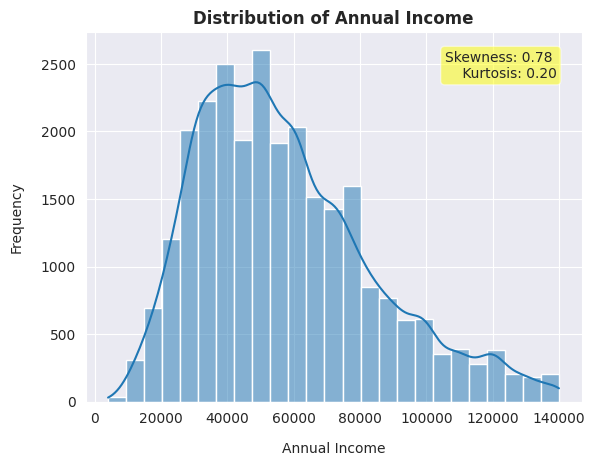

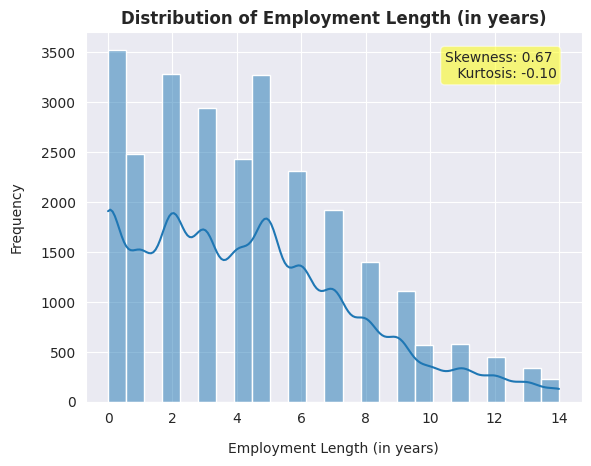

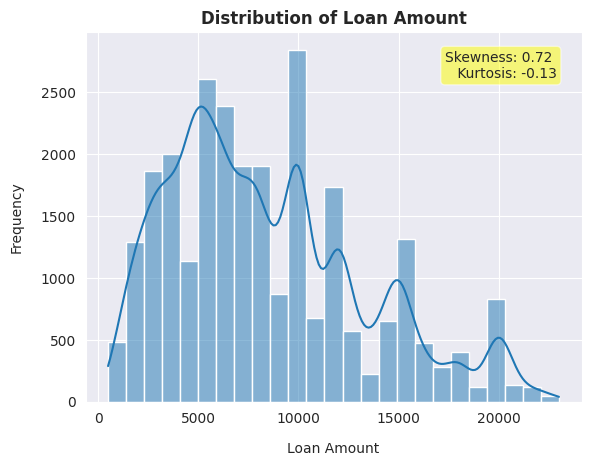

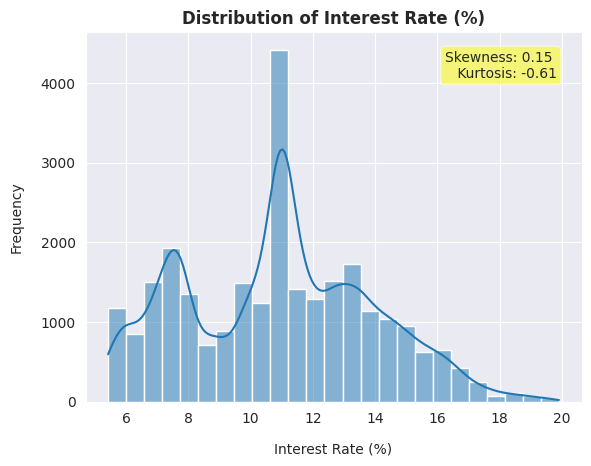

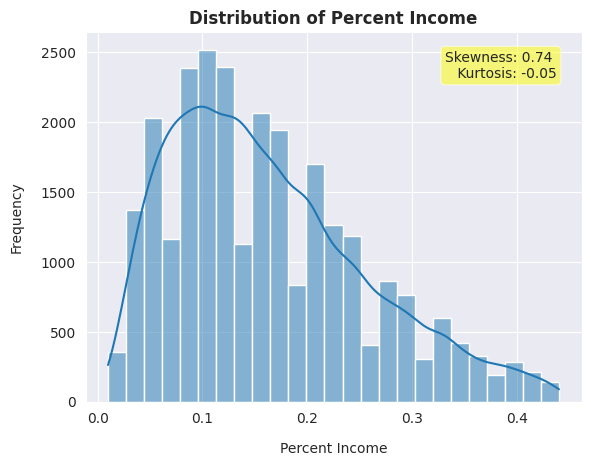

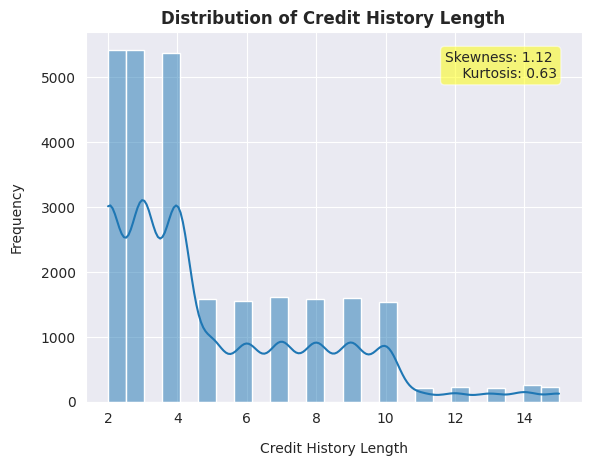

In [27]:
""" Plot histogram after removing outliers to understand new distribution """

for col in numerical_columns:
  fig, ax = plt.subplots()
  sns.histplot(credit[col],kde=True, bins=25)
  plt.title(f'Distribution of {feature_desc_mapping[col]}', fontweight='semibold')
  plt.text(0.95,0.95,f'Skewness: {credit[col].skew():.2f} \n Kurtosis: {credit[col].kurtosis():.2f}', transform = ax.transAxes, horizontalalignment = 'right', verticalalignment = 'top', bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))
  plt.xlabel(f'{feature_desc_mapping[col]}', labelpad=12)
  plt.ylabel('Frequency', labelpad=12)
  plt.show()

  # Print line break after each plot
  print('\n')

# Data Preprocessing
Preparation for model training

In [28]:
feature = credit.drop(columns='loan_status')
target = credit['loan_status']

"""Group data types"""
# Numerical columns
feature_num_columns = feature.select_dtypes(include=['int','float']).drop(columns='person_age',axis=1).columns

# Ordinal columns
feature_ord_columns = feature[['loan_grade']].columns

# Catgorical columns
feature_cat_columns = feature.select_dtypes(include=['object','category']).drop(columns='loan_grade',axis=1).columns

In [29]:
""" This section splits the dataset into training, validation and testing"""

# Split columns for training and testing
X_train, x_test, Y_train, y_test = train_test_split(feature, target, test_size = 0.001, random_state = 42)

# Split training data for validation and main training
X_Main_train, x_valid, Y_Main_train, y_valid = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 42)

In [30]:
# Get shape of split data
print(f'X_Main_train has {X_Main_train.shape[0]} rows for training')
print(f'Y_Main_train has {Y_Main_train.shape[0]} rows for training')
print(f'x_valid has {x_valid.shape[0]} rows for validation')
print(f'y_valid has {y_valid.shape[0]} rows for validation')
print(f'x_test has {x_test.shape[0]} rows for testing')
print(f'y_test has {y_test.shape[0]} rows for testing')

X_Main_train has 21444 rows for training
Y_Main_train has 21444 rows for training
x_valid has 5362 rows for validation
y_valid has 5362 rows for validation
x_test has 27 rows for testing
y_test has 27 rows for testing


In [31]:
# Make column transformation
preprocessor = ColumnTransformer([
    ('scaler', RobustScaler(), feature_num_columns),
    ('lencoder', OrdinalEncoder(categories=[['G','F','E','D','C','B','A']]), feature_ord_columns),
    ('one-hot', OneHotEncoder(handle_unknown='ignore'), feature_cat_columns)
    ], remainder = 'passthrough'
  )

# Baseline Model training






In [32]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('sampling', SMOTE()),
    ('model', RandomForestClassifier())
])

In [33]:
""" Multiple dictionaries to store models and model receiver operating characteristics result"""

# Create dictionary to store models
models = {
    'rfc': {
        'name':'Random Forest',
        'model': RandomForestClassifier(random_state=42)
    },
    'dtc': {
        'name': 'Decision Tree',
        'model': DecisionTreeClassifier(random_state=42)
    },
    'xgb': {
        'name': 'XGBoost',
        'model': XGBClassifier(random_state=42)
    },
    'lgrc': {
        'name': 'Logistic Regression',
        'model': LogisticRegression(random_state=42)
    },
    'svm': {
        'name': 'Support Vector Machine',
        'model': SVC(probability= True, random_state=42)
    }
}

# Dictionary to store receiver operating characteristics results
roc_results = {}

----------------------------------------------------------------------------------------------------
--> Random Forest <--
----------------------------------------------------------------------------------------------------
Accuracy Score 0.93 

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4295
           1       0.92      0.71      0.80      1067

    accuracy                           0.93      5362
   macro avg       0.93      0.85      0.88      5362
weighted avg       0.93      0.93      0.93      5362



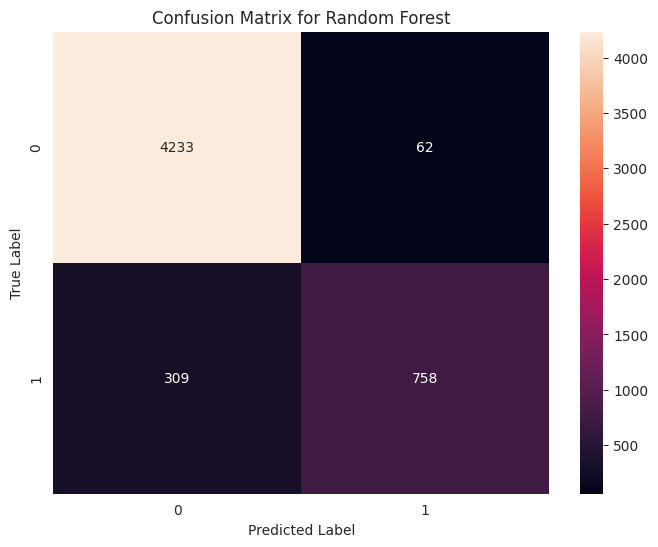




----------------------------------------------------------------------------------------------------
Predictions on test data by Random Forest
----------------------------------------------------------------------------------------------------
   True Label  Predcited Label Correct Predicition
0           1                1                 Yes
1           0                0                 Yes
2           0                0                 Yes
3           1                0                  No
4           0                0                 Yes
5           0                0                 Yes
6           0                0                 Yes
7           0                0                 Yes
8           1                1                 Yes
9           0                0                 Yes




----------------------------------------------------------------------------------------------------
--> Decision Tree <--
-----------------------------------------------------------------

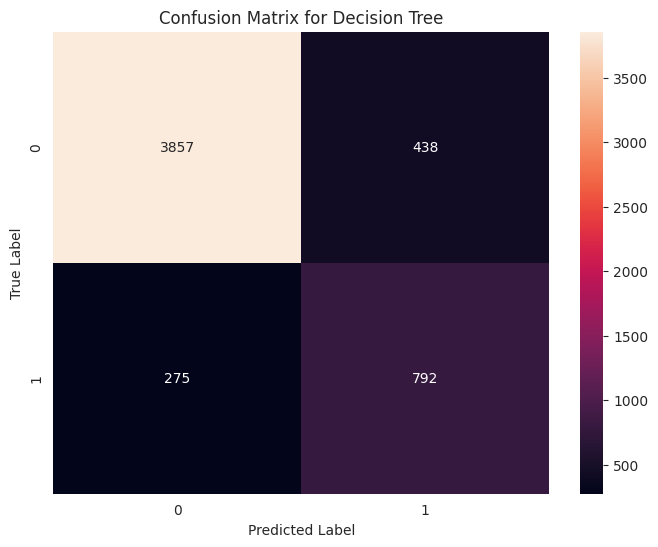




----------------------------------------------------------------------------------------------------
Predictions on test data by Decision Tree
----------------------------------------------------------------------------------------------------
   True Label  Predcited Label Correct Predicition
0           1                1                 Yes
1           0                0                 Yes
2           0                1                  No
3           1                0                  No
4           0                0                 Yes
5           0                0                 Yes
6           0                0                 Yes
7           0                0                 Yes
8           1                1                 Yes
9           0                0                 Yes




----------------------------------------------------------------------------------------------------
--> XGBoost <--
-----------------------------------------------------------------------

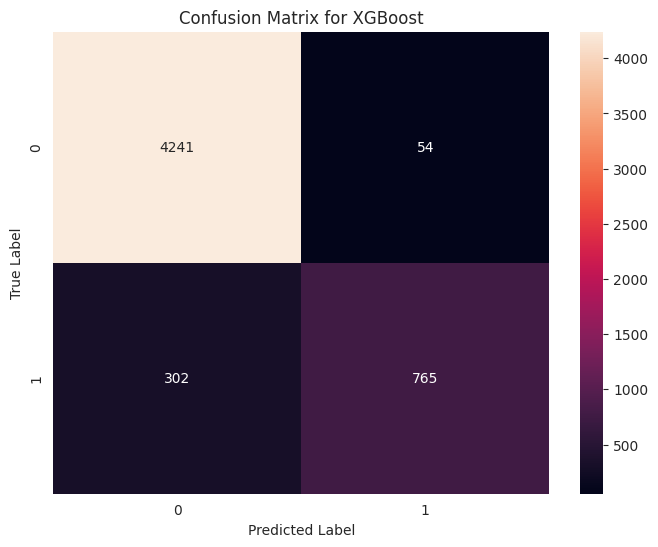




----------------------------------------------------------------------------------------------------
Predictions on test data by XGBoost
----------------------------------------------------------------------------------------------------
   True Label  Predcited Label Correct Predicition
0           1                1                 Yes
1           0                0                 Yes
2           0                0                 Yes
3           1                0                  No
4           0                0                 Yes
5           0                0                 Yes
6           0                0                 Yes
7           0                0                 Yes
8           1                1                 Yes
9           0                0                 Yes




----------------------------------------------------------------------------------------------------
--> Logistic Regression <--
-----------------------------------------------------------------

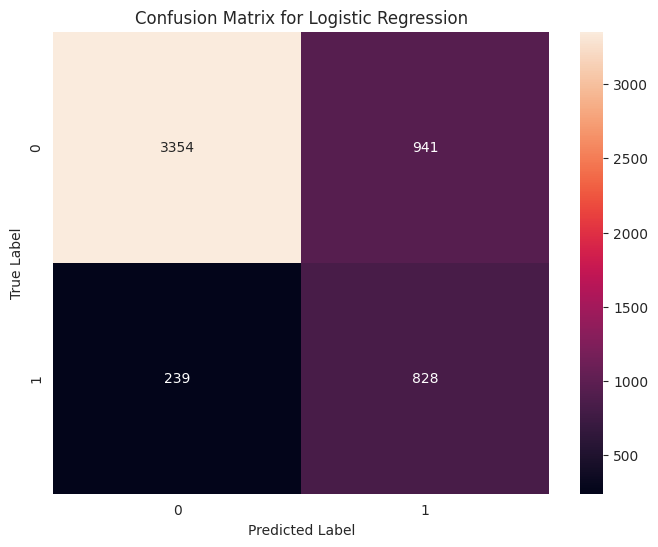




----------------------------------------------------------------------------------------------------
Predictions on test data by Logistic Regression
----------------------------------------------------------------------------------------------------
   True Label  Predcited Label Correct Predicition
0           1                1                 Yes
1           0                0                 Yes
2           0                1                  No
3           1                0                  No
4           0                1                  No
5           0                0                 Yes
6           0                0                 Yes
7           0                0                 Yes
8           1                1                 Yes
9           0                0                 Yes




----------------------------------------------------------------------------------------------------
--> Support Vector Machine <--
--------------------------------------------------

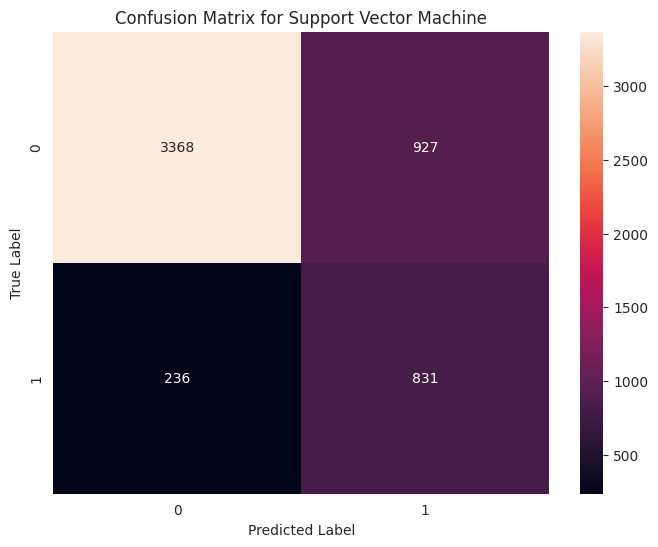




----------------------------------------------------------------------------------------------------
Predictions on test data by Support Vector Machine
----------------------------------------------------------------------------------------------------
   True Label  Predcited Label Correct Predicition
0           1                1                 Yes
1           0                0                 Yes
2           0                0                 Yes
3           1                0                  No
4           0                1                  No
5           0                0                 Yes
6           0                0                 Yes
7           0                0                 Yes
8           1                1                 Yes
9           0                0                 Yes






In [34]:
''' Training models by looping through the model dictionary while also outputing metrics'''

for abbr, model_dict in models.items():

  # Chnange the default model in the pipeline to the current running model
  pipeline.set_params(model = model_dict['model'])

  # Train model with split data
  pipeline.fit(X_Main_train,Y_Main_train)

  # Make prediction using
  y_pred = pipeline.predict(x_valid)

  # Get metrics
  acc_score = accuracy_score(y_valid,y_pred)
  class_report = classification_report(y_valid,y_pred)
  cm = confusion_matrix(y_valid,y_pred)

  # Show metrics
  print('-'*100)
  print(f'--> {model_dict['name']} <--')
  print('-'*100)

  print(f'Accuracy Score {acc_score:.2f} \n')
  print(class_report)

  # Plot the confusion matrix of the model
  plt.subplots(figsize=(8,6), dpi=100)
  sns.heatmap(cm,annot=True,fmt='d',cbar=True,)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title(f'Confusion Matrix for {model_dict['name']}')
  plt.show()

  # Add line break
  print('\n\n')

  """ Make predictions with each model on the test data """
  print('-'*100)
  print(f'Predictions on test data by {model_dict['name']}')
  print('-'*100)

  # Predict on unseen data from x_test
  y_test_pred = pipeline.predict(x_test)

  # Map predictions if they are equal
  correct_predicition = [ 'Yes' if y_test_pred[i] == y_test.iloc[i] else 'No' for i in range(len(y_test_pred)) ]

  # Dataframe to hold
  predicted = pd.DataFrame({
      'True Label' : y_test.values,
      'Predcited Label' : y_test_pred,
      'Correct Predicition' : correct_predicition
  })

  print(predicted.head(10))

  # Add line break
  print('\n\n\n')

  # End of prediction section

  # Empty dictionary for inner storage of each model result
  roc_results[abbr] = {}

  # Store data into each mdoel dictionaty
  roc_results[abbr]['name'] = model_dict['name']
  roc_results[abbr]['y_proba'] = pipeline.predict_proba(x_valid)[:, 1]
  roc_results[abbr]['fpr'],roc_results[abbr]['tpr'],roc_results[abbr]['thresholds'] = roc_curve(y_valid, roc_results[abbr]['y_proba'])
  roc_results[abbr]['roc_auc'] = roc_auc_score(y_valid, roc_results[abbr]['y_proba'])


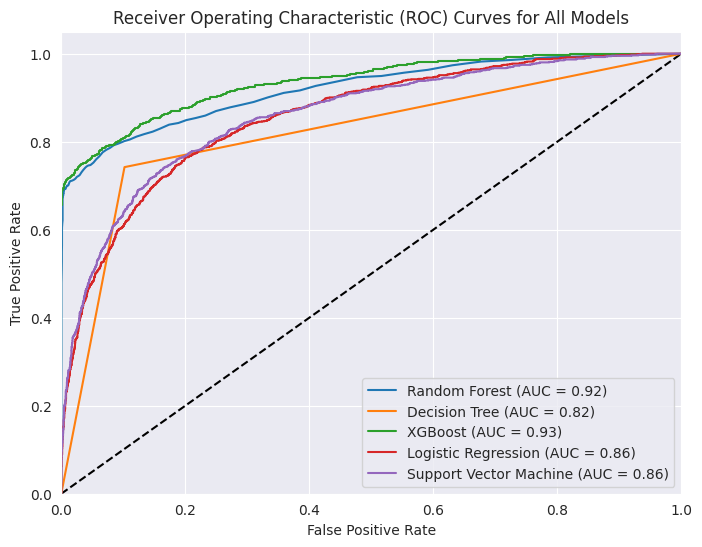

In [35]:
# Plot roc_curve for all models for comparison
plt.figure(figsize=(8, 6), dpi=100)
plt.plot([0, 1], [0, 1],  color='black', linestyle='--')

# plot each model result by looping through result dictionary
for result in roc_results.values():
  fpr,tpr = result['fpr'],result['tpr']
  roc_auc_result = result['roc_auc']
  plt.plot(fpr, tpr, label=f'{result['name']} (AUC = {roc_auc_result:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# **Hyper-Parameter Tunning**

In [36]:
""" Multiple dictionaries to store models with parameters for hyperparameters and model receiver operating characteristics result"""

# Create dictionary to store models
hyp_models = {
    'rfc': {
        'name':'Random Forest',
        'model': RandomForestClassifier(random_state=42),
        'params':{
            'model__n_estimators': [100,200,300,500],
            'model__max_depth': [None,5,10,20,30],
            'model__min_samples_split': [2,5,10],
            'model__min_samples_leaf': [1,2,4],
            'model__max_features': [None, 'sqrt', 'log2'],
            'model__bootstrap': [True, False]
        }
    },
    'dtc': {
        'name': 'Decision Tree',
        'model': DecisionTreeClassifier(random_state=42),
        'params':{
            'model__criterion': ['gini','entropy','log_loss'],
            'model__max_depth': [None,5,10,20,30],
            'model__min_samples_split': [2,5,10,20],
            'model__min_samples_leaf': [1,2,4,6],
            'model__max_features': [None, 'sqrt', 'log2']
        }
    },
    'xgb': {
        'name': 'XGBoost',
        'model': XGBClassifier(random_state=42),
        'params':{
            'model__n_estimators': [100,200,300],
            'model__max_depth': [3,5,7,10],
            'model__learning_rate': [0.01,0.05,0.1,0.2],
            'model__subsample': [0.6,0.8,1.0],
            'model__colsample_bytree': [0.6, 0.8, 1.0],
            'model__gamma': [0,1,5],
            'model__reg_alpha': [0,0.1,0.5],
            'model__reg_lambda': [1,1.5,2]
        }
    },
    'lgrc': {
        'name': 'Logistic Regression',
        'model': LogisticRegression(random_state=42),
        'params':{
            'model__penalty': ['l1','l2'],
            'model__C': [0.01,0.1,1,10,100],
            'model__solver': ['liblinear','saga'],
            'model__l1_ratio': [0,0.5,0.7,1]
        }
    },
    'svm': {
        'name': 'Support Vector Machine',
        'model': SVC(probability= True, random_state=42),
        'params':{
            'model__C': [0.01,0.1,1,10],
            'model__kernel': ['linear']
        }
    }
}

# Dictionary to store receiver operating characteristics results
hp_roc_results = {}

----------------------------------------------------------------------------------------------------
--> Random Forest <--
----------------------------------------------------------------------------------------------------
Accuracy Score 0.93 

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4295
           1       0.93      0.71      0.80      1067

    accuracy                           0.93      5362
   macro avg       0.93      0.85      0.88      5362
weighted avg       0.93      0.93      0.93      5362



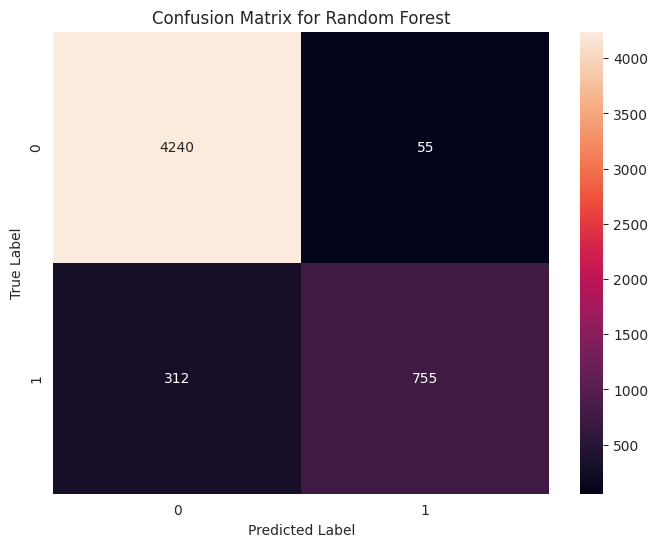




----------------------------------------------------------------------------------------------------
Predictions on test data by Random Forest
----------------------------------------------------------------------------------------------------
   True Label  Predcited Label Correct Predicition
0           1                1                 Yes
1           0                0                 Yes
2           0                0                 Yes
3           1                0                  No
4           0                0                 Yes
5           0                0                 Yes
6           0                0                 Yes
7           0                0                 Yes
8           1                1                 Yes
9           0                0                 Yes




----------------------------------------------------------------------------------------------------
--> Decision Tree <--
-----------------------------------------------------------------

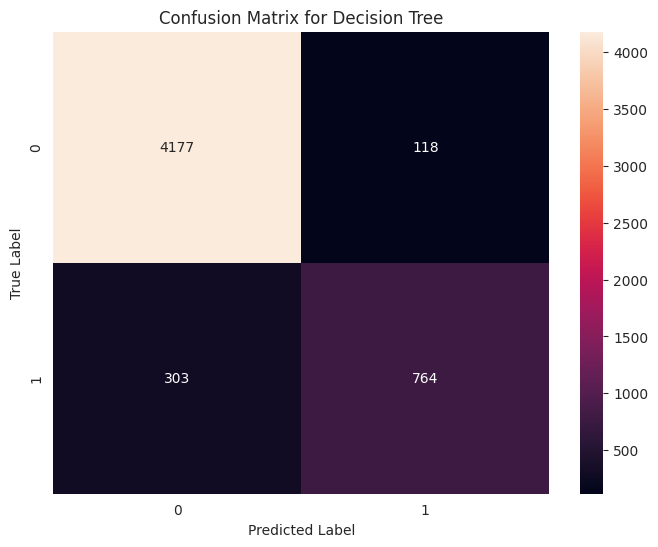




----------------------------------------------------------------------------------------------------
Predictions on test data by Decision Tree
----------------------------------------------------------------------------------------------------
   True Label  Predcited Label Correct Predicition
0           1                1                 Yes
1           0                0                 Yes
2           0                0                 Yes
3           1                0                  No
4           0                0                 Yes
5           0                0                 Yes
6           0                0                 Yes
7           0                0                 Yes
8           1                1                 Yes
9           0                0                 Yes




----------------------------------------------------------------------------------------------------
--> XGBoost <--
-----------------------------------------------------------------------

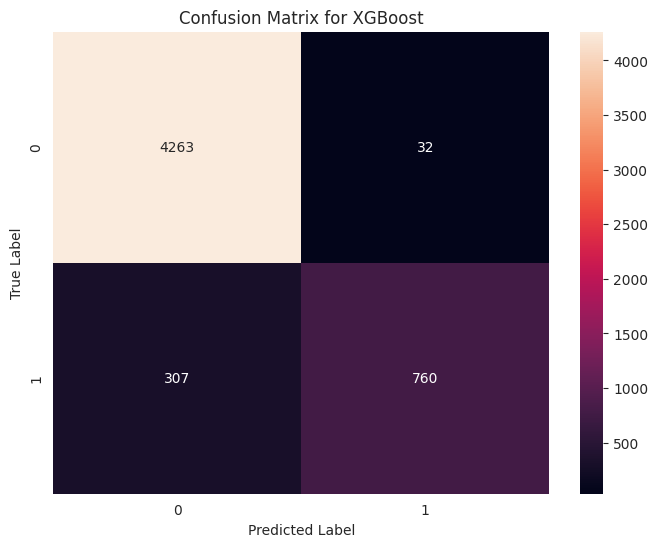




----------------------------------------------------------------------------------------------------
Predictions on test data by XGBoost
----------------------------------------------------------------------------------------------------
   True Label  Predcited Label Correct Predicition
0           1                1                 Yes
1           0                0                 Yes
2           0                0                 Yes
3           1                0                  No
4           0                0                 Yes
5           0                0                 Yes
6           0                0                 Yes
7           0                0                 Yes
8           1                1                 Yes
9           0                0                 Yes




----------------------------------------------------------------------------------------------------
--> Logistic Regression <--
-----------------------------------------------------------------

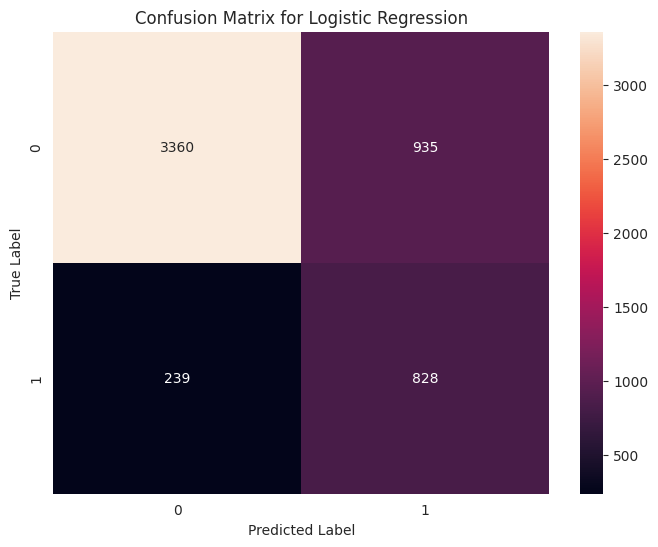




----------------------------------------------------------------------------------------------------
Predictions on test data by Logistic Regression
----------------------------------------------------------------------------------------------------
   True Label  Predcited Label Correct Predicition
0           1                1                 Yes
1           0                0                 Yes
2           0                1                  No
3           1                0                  No
4           0                1                  No
5           0                0                 Yes
6           0                0                 Yes
7           0                0                 Yes
8           1                1                 Yes
9           0                0                 Yes






In [ ]:
''' Training models by looping through the hyperparameter model dictionary while also outputing metrics'''

for abbr, model_dict in hyp_models.items():

  # Change the default model in the pipeline to the current running model
  pipeline.set_params(model = model_dict['model'])

  # Use the randomizedsearch CV to find the best model and perform the prediction
  model_search = RandomizedSearchCV(pipeline, model_dict['params'], n_iter=20,cv=3, scoring='accuracy', n_jobs=-1, random_state=42)

  # Fit data for training
  model_search.fit(X_Main_train,Y_Main_train)

  # Find the best estimator from the randomizedsearchcv
  best_search = model_search.best_estimator_

  # Make prediction using
  y_pred = best_search.predict(x_valid)

  # Get metrics
  acc_score = accuracy_score(y_valid,y_pred)
  class_report = classification_report(y_valid,y_pred)
  cm = confusion_matrix(y_valid,y_pred)

  #-----------------------------------------------------------------

  # Show metrics
  print('-'*100)
  print(f'--> {model_dict['name']} <--')
  print('\n')
  #Print the best estimator
  print(f'Best Estimator: {best_search}')
  print('-'*100)


  print(f'Accuracy Score {acc_score:.2f} \n')
  print(class_report)

  #-----------------------------------------------------------------

  # Plot the confusion matrix of the model
  plt.subplots(figsize=(8,6), dpi=100)
  sns.heatmap(cm,annot=True,fmt='d',cbar=True,)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title(f'Confusion Matrix for {model_dict['name']}')
  plt.show()

  # Add line break
  print('\n\n')

  #-----------------------------------------------------------------

  """ Make predictions with each model on the test data """
  print('-'*100)
  print(f'Predictions on test data by {model_dict['name']}')
  print('-'*100)

  #-----------------------------------------------------------------

  # Print the feature importance
  if abbr == 'lgrc' or abbr == 'svm'
    importance = pipeline.named_steps['model'].coef_
  else:
    importance = pipeline.named_steps['model'].feature_importances_

  # Create dataframe to output columns and importance as a dataframe
  df_importance = pd.DataFrame({
      'columns': X_Main_Train.columns,
      'importance': importance
  })

  # Print the importance dataframe
  print(f'Feature importance for {model_dict["name"]}')
  print(df_importance.sort_values(by='importance', ascending=False))

  #-----------------------------------------------------------------

  # Predict on unseen data from x_test
  y_test_pred = best_search.predict(x_test)

  # Map predictions if they are equal
  correct_predicition = [ 'Yes' if y_test_pred[i] == y_test.iloc[i] else 'No' for i in range(len(y_test_pred)) ]

  # Dataframe to hold
  predicted = pd.DataFrame({
      'True Label' : y_test.values,
      'Predcited Label' : y_test_pred,
      'Correct Predicition' : correct_predicition
  })

  print(predicted.head(10))

  # Add line break
  print('\n\n\n')

  # End of prediction section

  #-----------------------------------------------------------------

  # Empty dictionary for inner storage of each model result
  hp_roc_results[abbr] = {}

  # Store data into each mdoel dictionaty
  hp_roc_results[abbr]['name'] = model_dict['name']
  hp_roc_results[abbr]['y_proba'] = best_search.predict_proba(x_valid)[:, 1]
  hp_roc_results[abbr]['fpr'],hp_roc_results[abbr]['tpr'],hp_roc_results[abbr]['thresholds'] = roc_curve(y_valid, hp_roc_results[abbr]['y_proba'])
  hp_roc_results[abbr]['roc_auc'] = hp_roc_auc_score(y_valid, hp_roc_results[abbr]['y_proba'])

  #-----------------------------------------------------------------


In [ ]:
# Plot roc_curve for all models for comparison
plt.figure(figsize=(8, 6), dpi=100)
plt.plot([0, 1], [0, 1],  color='black', linestyle='--')

# plot each model result by looping through result dictionary
for result in hp_roc_results.values():
  fpr,tpr = result['fpr'],result['tpr']
  hp_roc_auc_result = result['roc_auc']
  plt.plot(fpr, tpr, label=f'{result['name']} (AUC = {hp_roc_auc_result:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()